# SOAL 3 (Bagian 1): Modeling & Evaluation
Tujuan: Membangun model Machine Learning (Random Forest & XGBoost), melakukan hyperparameter tuning, dan mengevaluasi performa terbaik.

In [7]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

# 1. Load Data hasil Preprocessing
# Membaca file pickle yang kita simpan di 01_eda.ipynb
# Load Data
data = joblib.load('../data/processed/split_data.pkl')
X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']

print("Data berhasil dimuat!")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Data berhasil dimuat!
Training set: (8000, 6), Test set: (2000, 6)


In [8]:
# gunakan 2 Model Berbeda:
# 1. Random Forest: Bagus untuk baseline, tahan overfitting, interpretability lumayan.
# 2. XGBoost: State-of-the-art untuk data tabular, performa tinggi.

# Handling Imbalance Class:
# Karena jumlah 'Failure' sedikit, kita pakai parameter class_weight (RF) atau scale_pos_weight (XGB)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=ratio, eval_metric='logloss')
}

print(f"Rasio Imbalance (untuk XGBoost): {ratio:.2f}")

Rasio Imbalance (untuk XGBoost): 28.52


In [9]:
results = {}

print("=== HASIL EVALUASI BASELINE ===")
for name, model in models.items():
    # Training
    model.fit(X_train, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Hitung Metrik
    roc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {'model': model, 'ROC-AUC': roc, 'F1-Score': f1}
    
    print(f"\nModel: {name}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"F1-Score (Class 1): {f1:.4f}")
    print("-" * 30)

=== HASIL EVALUASI BASELINE ===

Model: Random Forest
ROC-AUC: 0.9696
F1-Score (Class 1): 0.6847
------------------------------

Model: XGBoost
ROC-AUC: 0.9675
F1-Score (Class 1): 0.7626
------------------------------


In [10]:
# Kita lakukan Tuning pada XGBoost karena biasanya performanya paling bisa didorong
# Teknik: RandomizedSearchCV (Lebih cepat daripada GridSearch)

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_tuned = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, scale_pos_weight=ratio, eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=20, # Mencoba 20 kombinasi acak
    scoring='f1', # Kita optimalkan F1-Score karena fokus deteksi kegagalan
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Mulai Tuning XGBoost...")
xgb_tuned.fit(X_train, y_train)

print(f"\nBest Parameters: {xgb_tuned.best_params_}")
print(f"Best F1-Score (CV): {xgb_tuned.best_score_:.4f}")

# Simpan model terbaik ke dictionary results
results['XGBoost Tuned'] = {
    'model': xgb_tuned.best_estimator_,
    'ROC-AUC': roc_auc_score(y_test, xgb_tuned.predict_proba(X_test)[:, 1]),
    'F1-Score': f1_score(y_test, xgb_tuned.predict(X_test))
}

Mulai Tuning XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best F1-Score (CV): 0.7138



=== TABEL PERBANDINGAN PERFORMA ===
           Model   ROC-AUC  F1-Score
1        XGBoost  0.967528  0.762590
2  XGBoost Tuned  0.977599  0.757143
0  Random Forest  0.969603  0.684685

Model Terbaik Dipilih: XGBoost


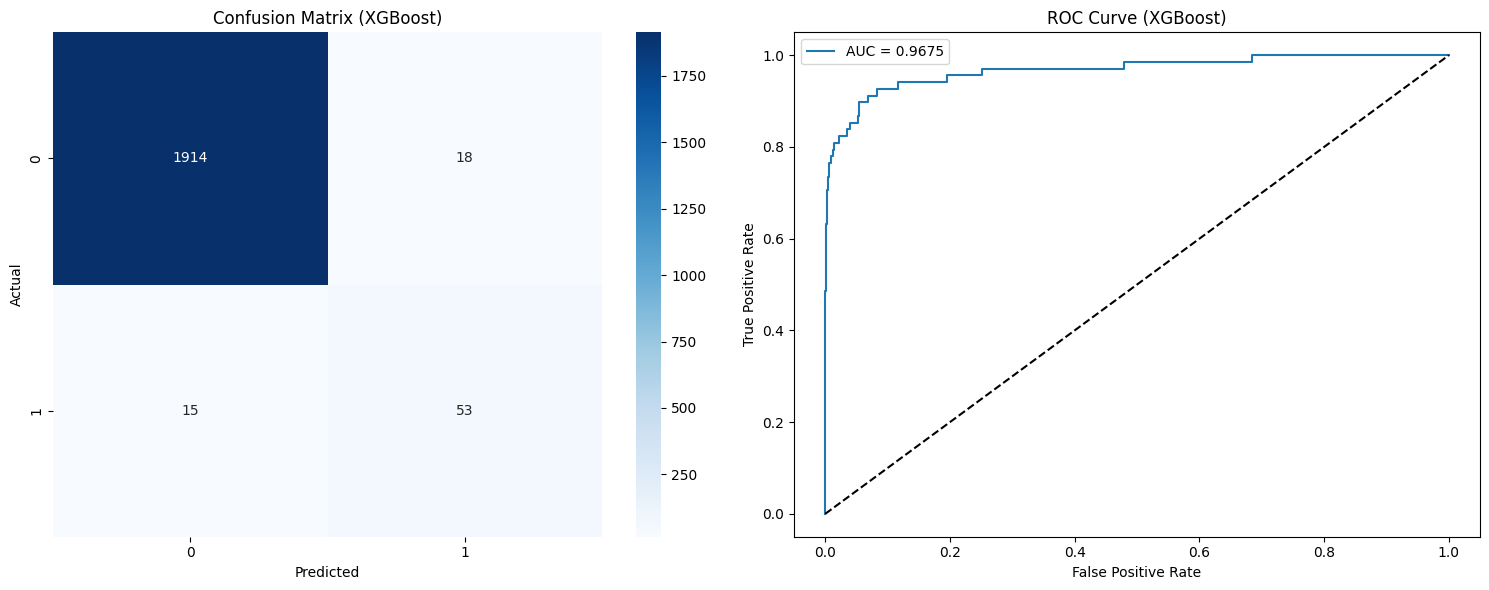


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.75      0.78      0.76        68

    accuracy                           0.98      2000
   macro avg       0.87      0.89      0.88      2000
weighted avg       0.98      0.98      0.98      2000



In [11]:
# 1. Tabel Perbandingan
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [res['ROC-AUC'] for res in results.values()],
    'F1-Score': [res['F1-Score'] for res in results.values()]
})

print("\n=== TABEL PERBANDINGAN PERFORMA ===")
print(metrics_df.sort_values(by='F1-Score', ascending=False))

# 2. Confusion Matrix & ROC Curve untuk Model Terbaik
best_model_name = metrics_df.sort_values(by='F1-Score', ascending=False).iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nModel Terbaik Dipilih: {best_model_name}")

y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Confusion Matrix ({best_model_name})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_best):.4f}")
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title(f'ROC Curve ({best_model_name})')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

plt.tight_layout()
plt.show()

# Classification Report Lengkap
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_best))

In [12]:
# Simpan Model Terbaik ke folder MODELS
# Sesuai permintaan: models/best_model.pkl
joblib.dump(best_model, '../models/best_model.pkl')
print("Model terbaik disimpan di: models/best_model.pkl")

Model terbaik disimpan di: models/best_model.pkl
